In [27]:
import os

from dotenv import load_dotenv

load_dotenv(os.path.join("..", ".env"), override=True)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 연구용 딥 에이전트

## 개요 

<img src="./assets/agent_header.png" width="800" style="display:block; margin-left:0;">

이제 배운 모든 것을 하나로 모을 수 있습니다:

* **TODO**를 사용하여 작업을 추적합니다. 
* 원시 도구 호출 결과를 저장하기 위해 **파일**을 사용합니다. 
* 컨텍스트 격리를 위해 **연구 작업을 하위 에이전트에게 위임**합니다. 

## 검색 도구 

원시 콘텐츠를 파일로 오프로드하고 요약만 에이전트에 반환하는 검색 도구를 구축할 것입니다. 이는 장기 실행 에이전트 궤적의 일반적인 패턴입니다. [Manus에서 보았듯이](https://manus.im/blog/Context-Engineering-for-AI-Agents-Lessons-from-Building-Manus)! 

### 핵심 구성 요소

1. **검색 실행 (`run_tavily_search`)**: 결과 수 및 주제 필터링을 위한 구성 가능한 매개변수를 사용하여 Tavily API를 통해 실제 웹 검색을 수행합니다.

2. **콘텐츠 요약 (`summarize_webpage_content`)**: 경량 모델(GPT-4o-mini)을 사용하여 웹페이지 콘텐츠의 구조화된 요약을 생성하여 설명적인 파일 이름과 주요 학습 요약을 모두 생성합니다.

3. **결과 처리 (`process_search_results`)**: HTTP를 통해 전체 웹페이지 콘텐츠를 가져오고, `markdownify`를 사용하여 HTML을 마크다운으로 변환하고, 각 결과에 대한 요약을 생성합니다.

4. **컨텍스트 오프로드 (`tavily_search` 도구)**: 다음을 수행하는 기본 도구:
   - 검색을 실행하고 결과를 처리합니다.
   - 에이전트 상태의 파일에 전체 콘텐츠를 저장합니다(컨텍스트 오프로드).
   - 에이전트에 최소한의 요약만 반환합니다(컨텍스트 스팸 방지).
   - LangGraph `Command`를 사용하여 파일과 메시지를 모두 업데이트합니다.

5. **전략적 사고 (`think_tool`)**: 에이전트가 연구 결과를 분석하고, 격차를 평가하고, 연구 워크플로우의 다음 단계를 계획할 수 있는 구조화된 반영 메커니즘을 제공합니다.

이 아키텍처는 상세한 검색 결과를 파일에 저장하고 에이전트의 작업 컨텍스트를 최소화하고 집중하여 토큰 효율성 문제를 해결합니다.

In [28]:
%%writefile ../src/deep_agents_from_scratch/research_tools.py
"""연구 도구 모음입니다.

이 모듈은 연구 에이전트를 위한 검색 및 콘텐츠 처리 유틸리티를 제공합니다.
웹 검색 기능과 콘텐츠 요약 도구 등이 포함되어 있습니다.
"""
import os
from datetime import datetime
import uuid, base64

import httpx
from langchain.chat_models import init_chat_model
from langchain_core.messages import HumanMessage, ToolMessage
from langchain_core.tools import InjectedToolArg, InjectedToolCallId, tool
from langgraph.prebuilt import InjectedState
from langgraph.types import Command
from markdownify import markdownify
from pydantic import BaseModel, Field
from tavily import TavilyClient
from typing_extensions import Annotated, Literal

from deep_agents_from_scratch.prompts import SUMMARIZE_WEB_SEARCH
from deep_agents_from_scratch.state import DeepAgentState

# 📝 웹페이지 내용을 요약하는 데 사용할 모델을 설정합니다.
# 여기서는 가볍고 빠른 모델을 사용하여 비용과 속도를 최적화해요!
summarization_model = init_chat_model(model="google_genai:gemini-2.5-flash")
# 🔍 Tavily API 클라이언트를 초기화합니다. AI 에이전트를 위한 똑똑한 검색 엔진이죠.
tavily_client = TavilyClient()

class Summary(BaseModel):
	"""웹페이지 콘텐츠 요약을 위한 스키마입니다."""
	filename: str = Field(description="저장할 파일의 이름입니다.")
	summary: str = Field(description="웹페이지의 핵심 학습 내용입니다.")

def get_today_str() -> str:
	"""사람이 읽기 쉬운 형식으로 현재 날짜를 가져옵니다."""
	return datetime.now().strftime("%a %b %-d, %Y")

def run_tavily_search(
	search_query: str, 
	max_results: int = 1, 
	topic: Literal["general", "news", "finance"] = "general", 
	include_raw_content: bool = True, 
) -> dict:
	"""단일 쿼리에 대해 Tavily API를 사용하여 검색을 수행합니다.

	Args:
		search_query: 실행할 검색 쿼리입니다.
		max_results: 쿼리당 최대 결과 수입니다.
		topic: 검색 결과에 대한 주제 필터입니다.
		include_raw_content: 원시 웹페이지 콘텐츠 포함 여부입니다.

	Returns:
		검색 결과 딕셔너리를 반환합니다.
	"""
	# 🕵️‍♂️ Tavily 검색을 실행하여 웹에서 정보를 찾아옵니다.
	result = tavily_client.search(
		search_query,
		max_results=max_results,
		include_raw_content=include_raw_content,
		topic=topic
	)

	return result

def summarize_webpage_content(webpage_content: str) -> Summary:
	"""구성된 요약 모델을 사용하여 웹페이지 콘텐츠를 요약합니다.
	
	Args:
		webpage_content: 요약할 원시 웹페이지 콘텐츠입니다.
		
	Returns:
		파일명과 요약이 포함된 Summary 객체를 반환합니다.
	"""
	try:
		# ✨ 요약을 위해 구조화된 출력 모델을 설정합니다. 이렇게 하면 항상 일관된 형식의 결과를 얻을 수 있어요.
		structured_model = summarization_model.with_structured_output(Summary)
		
		# 🤖 요약을 생성합니다. 프롬프트에 오늘 날짜 정보도 함께 넣어주어 최신성을 더합니다.
		summary_and_filename = structured_model.invoke([
			HumanMessage(content=SUMMARIZE_WEB_SEARCH.format(
				webpage_content=webpage_content, 
				date=get_today_str()
			))
		])
		
		return summary_and_filename
		
	except Exception:
		# 🚨 만약 요약 과정에서 오류가 발생하면, 기본적인 요약 객체를 대신 반환하여 시스템이 멈추지 않도록 합니다.
		return Summary(
			filename="search_result.md",
			summary=webpage_content[:1000] + "..." if len(webpage_content) > 1000 else webpage_content
		)

def process_search_results(results: dict) -> list[dict]:
	"""사용 가능한 경우 콘텐츠를 요약하여 검색 결과를 처리합니다.
	
	Args:
		results: Tavily 검색 결과 딕셔너리입니다.
		
	Returns:
		요약이 포함된 처리된 결과 목록을 반환합니다.
	"""
	processed_results = []

	# 🌐 HTTP 요청을 위한 클라이언트를 생성합니다.
	HTTPX_CLIENT = httpx.Client()
	
	for result in results.get('results', []):
		
		# 🔗 결과에서 URL을 가져옵니다.
		url = result['url']
		
		# 📥 URL의 내용을 읽어옵니다.
		response = HTTPX_CLIENT.get(url)

		if response.status_code == 200:
			# ✅ 성공적으로 페이지를 읽었다면, HTML을 마크다운으로 변환하고 내용을 요약합니다.
			raw_content = markdownify(response.text)
			summary_obj = summarize_webpage_content(raw_content)
		else:
			# ❌ URL을 읽는데 실패했다면, Tavily가 제공하는 기본 요약을 사용합니다.
			raw_content = result.get('raw_content', '')
			summary_obj = Summary(
				filename="URL_error.md",
				summary=result.get('content', 'URL을 읽는 중 오류 발생; 다른 검색을 시도해보세요.')
			)
		
		# 📛 파일 이름이 겹치지 않도록 고유한 ID를 생성하여 붙여줍니다.
		uid = base64.urlsafe_b64encode(uuid.uuid4().bytes).rstrip(b"=").decode("ascii")[:8]
		name, ext = os.path.splitext(summary_obj.filename)
		summary_obj.filename = f"{name}_{uid}{ext}"

		processed_results.append({
			'url': result['url'],
			'title': result['title'],
			'summary': summary_obj.summary,
			'filename': summary_obj.filename,
			'raw_content': raw_content,
		})
	
	return processed_results

@tool(parse_docstring=True)
def tavily_search(
	query: str,
	state: Annotated[DeepAgentState, InjectedState],
	tool_call_id: Annotated[str, InjectedToolCallId],
	max_results: Annotated[int, InjectedToolArg] = 1,
	topic: Annotated[Literal["general", "news", "finance"], InjectedToolArg] = "general",
) -> Command:
	"""최소한의 컨텍스트를 반환하면서 상세한 결과를 파일에 저장하고 웹을 검색합니다.

	웹 검색을 수행하고 전체 콘텐츠를 파일에 저장하여 컨텍스트를 오프로드합니다.
	에이전트가 다음 단계를 결정하는 데 도움이 되는 필수 정보만 반환합니다.

	Args:
		query: 실행할 검색 쿼리입니다.
		state: 파일 저장을 위한 주입된 에이전트 상태입니다.
		tool_call_id: 주입된 도구 호출 식별자입니다.
		max_results: 반환할 최대 결과 수 (기본값: 1) 입니다.
		topic: 주제 필터 - 'general', 'news', 또는 'finance' (기본값: 'general') 입니다.

	Returns:
		전체 결과를 파일에 저장하고 최소한의 요약을 제공하는 Command를 반환합니다.
	"""
	# 🚀 검색을 실행합니다.
	search_results = run_tavily_search(
		query,
		max_results=max_results,
		topic=topic,
		include_raw_content=True,
	) 

	# 🔄 결과를 처리하고 요약합니다.
	processed_results = process_search_results(search_results)
	
	# 💾 각 결과를 파일에 저장하고 요약을 준비합니다.
	files = state.get("files", {})
	saved_files = []
	summaries = []
	
	for i, result in enumerate(processed_results):
		# AI가 생성한 파일 이름을 사용합니다.
		filename = result['filename']
		
		# 📄 전체 세부 정보가 포함된 파일 콘텐츠를 생성합니다.
		file_content = f"""# 검색 결과: {result['title']}

**URL:** {result['url']}
**쿼리:** {query}
**날짜:** {get_today_str()}

## 요약
{result['summary']}

## 원본 콘텐츠
{result['raw_content'] if result['raw_content'] else '사용 가능한 원본 콘텐츠 없음'}
"""
		
		files[filename] = file_content
		saved_files.append(filename)
		summaries.append(f"- {filename}: {result['summary']}...")
	
	# 📝 도구 메시지를 위한 최소한의 요약을 생성합니다. 무엇을 수집했는지에 초점을 맞춥니다.
	summary_text = f"""🔍 '{query}'에 대한 {len(processed_results)}개의 결과를 찾았습니다:

{chr(10).join(summaries)}

파일: {', '.join(saved_files)}
💡 필요할 때 `read_file()`을 사용하여 전체 세부 정보에 액세스하세요."""

	return Command(
		update={
			"files": files,
			"messages": [
				ToolMessage(summary_text, tool_call_id=tool_call_id)
			],
		}
	)

@tool(parse_docstring=True)
def think_tool(reflection: str) -> str:
	"""연구 진행 상황 및 의사 결정에 대한 전략적 성찰을 위한 도구입니다.

	각 검색 후에 이 도구를 사용하여 결과를 분석하고 다음 단계를 체계적으로 계획하세요.
	이는 양질의 의사 결정을 위해 연구 워크플로우에 의도적인 멈춤을 만듭니다.

	사용 시기:
	- 검색 결과를 받은 후: 어떤 핵심 정보를 찾았는가?
	- 다음 단계를 결정하기 전: 포괄적으로 답변하기에 충분한 정보가 있는가?
	- 연구 격차를 평가할 때: 구체적으로 어떤 정보가 아직 부족한가?
	- 연구를 마치기 전: 이제 완전한 답변을 제공할 수 있는가?
	- 질문이 얼마나 복잡한가: 검색 제한 횟수에 도달했는가?

	성찰은 다음을 다루어야 합니다:
	1. 현재 결과 분석 - 어떤 구체적인 정보를 수집했는가?
	2. 격차 평가 - 어떤 중요한 정보가 여전히 부족한가?
	3. 품질 평가 - 좋은 답변을 위한 충분한 증거나 예시가 있는가?
	4. 전략적 결정 - 검색을 계속해야 하는가, 아니면 답변을 제공해야 하는가?

	Args:
		reflection: 연구 진행 상황, 결과, 격차 및 다음 단계에 대한 상세한 성찰입니다.

	Returns:
		의사 결정을 위해 성찰이 기록되었다는 확인 메시지를 반환합니다.
	"""
	return f"성찰 기록됨: {reflection}"

Overwriting ../src/deep_agents_from_scratch/research_tools.py


## 딥 에이전트

이제 이전 학습 내용을 모두 적용할 수 있습니다: 

* 연구원에게 `think_tool`과 위에 있는 `search_tool`을 제공할 것입니다.
* 부모 에이전트 파일 도구, `think_tool`, `task` 도구를 제공할 것입니다. 

In [29]:
from datetime import datetime

from IPython.display import Image, display
from langchain.chat_models import init_chat_model
from langgraph.prebuilt import create_react_agent
from utils import show_prompt, stream_agent

# 📂 파일 시스템, 프롬프트, 도구 등 에이전트에 필요한 모든 구성 요소를 가져옵니다.
# 우리가 이전에 만들었던 기능들을 여기서 모두 조립한다고 생각하시면 돼요!
from deep_agents_from_scratch.file_tools import ls, read_file, write_file
from deep_agents_from_scratch.prompts import (
	FILE_USAGE_INSTRUCTIONS,
	RESEARCHER_INSTRUCTIONS,
	SUBAGENT_USAGE_INSTRUCTIONS,
	TODO_USAGE_INSTRUCTIONS,
)
from deep_agents_from_scratch.research_tools import tavily_search, think_tool, get_today_str
from deep_agents_from_scratch.state import DeepAgentState
from deep_agents_from_scratch.task_tool import _create_task_tool
from deep_agents_from_scratch.todo_tools import write_todos, read_todos

# 🤖 `create_react_agent`를 사용하여 직접 에이전트를 생성합니다.
# 사용할 모델과 온도를 설정합니다. 온도가 0이면 가장 결정적인 답변을 생성해요.
model = init_chat_model(model="google_genai:gemini-2.5-flash", temperature=0.0)

# 🚦 에이전트의 행동을 제어하기 위한 한계를 설정합니다.
# 동시에 실행할 수 있는 최대 연구 단위와, 연구 에이전트의 최대 반복 횟수를 정해줘요.
max_concurrent_research_units = 3
max_researcher_iterations = 3

# 🛠️ 에이전트가 사용할 도구들을 종류별로 정리합니다.
# 하위 에이전트용 도구, 기본 내장 도구 등을 명확히 구분하면 관리하기 편해요.
sub_agent_tools = [tavily_search, think_tool]
built_in_tools = [ls, read_file, write_file, write_todos, read_todos, think_tool]

# 🕵️‍♂️ 연구를 전문으로 하는 하위 에이전트를 정의합니다.
# 이름, 설명, 프롬프트, 그리고 사용할 도구를 지정해서 역할을 명확하게 부여해요.
research_sub_agent = {
	"name": "research-agent",
	"description": "하위 에이전트 연구원에게 연구를 위임합니다. 이 연구원에게는 한 번에 하나의 주제만 주세요.",
	"prompt": RESEARCHER_INSTRUCTIONS.format(date=get_today_str()),
	"tools": ["tavily_search", "think_tool"],
}

# ✨ 작업을 하위 에이전트에게 위임할 수 있는 'task' 도구를 생성합니다.
# 이 도구가 바로 메인 에이전트와 하위 에이전트를 연결하는 핵심적인 다리 역할을 합니다.
task_tool = _create_task_tool(
	sub_agent_tools, [research_sub_agent], model, DeepAgentState
)

# 🤝 위임 도구를 목록에 추가하고, 모든 도구를 하나로 합칩니다.
# 메인 에이전트는 이 'all_tools' 목록에 있는 모든 도구를 사용할 수 있게 됩니다.
delegation_tools = [task_tool]
all_tools = sub_agent_tools + built_in_tools + delegation_tools  # 간단한 경우에는 메인 에이전트도 검색을 사용할 수 있도록 합니다.

# 📝 에이전트에게 전달할 최종 프롬프트(사용 설명서)를 만듭니다.
# 여기에는 하위 에이전트 사용법에 대한 지침이 포함됩니다.
SUBAGENT_INSTRUCTIONS = SUBAGENT_USAGE_INSTRUCTIONS.format(
	max_concurrent_research_units=max_concurrent_research_units,
	max_researcher_iterations=max_researcher_iterations,
	date=datetime.now().strftime("%a %b %-d, %Y"),
)

E0000 00:00:1760679213.094310  540781 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


In [30]:
show_prompt(RESEARCHER_INSTRUCTIONS)

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  You are a research assistant conducting research on the user's input topic. For context, today's date is       │
│  {date}.                                                                                                        │
│                                                                                                                 │
│  <Task>                                                                                                         │
│  Your job is to use tools to gather information about the user's input topic.                                   │
│  You can use any of the tools provided to you to find resources that can help answer the research question.     │
│  You can call these tools in series or in parallel, your research is conducted in a tool-calling loop.          │
│  </Task>                                                                                                        │
│                                                                                                                 │
│  <Available Tools>                                                                                              │
│  You have access to two main tools:                                                                             │
│  1. **tavily_search**: For conducting web searches to gather information                                        │
│  2. **think_tool**: For reflection and strategic planning during research                                       │
│                                                                                                                 │
│  **CRITICAL: Use think_tool after each search to reflect on results and plan next steps**                       │
│  </Available Tools>                                                                                             │
│                                                                                                                 │
│  <Instructions>                                                                                                 │
│  Think like a human researcher with limited time. Follow these steps:                                           │
│                                                                                                                 │
│  1. **Read the question carefully** - What specific information does the user need?                             │
│  2. **Start with broader searches** - Use broad, comprehensive queries first                                    │
│  3. **After each search, pause and assess** - Do I have enough to answer? What's still missing?                 │
│  4. **Execute narrower searches as you gather information** - Fill in the gaps                                  │
│  5. **Stop when you can answer confidently** - Don't keep searching for perfection                              │
│  </Instructions>                                                                                                │
│                                                                                                                 │
│  <Hard Limits>                                                                                                  │
│  **Tool Call Budgets** (Prevent excessive searching):                                                           │
│  - **Simple queries**: Use 1-2 search tool calls maximum                                                        │
│  - **Normal queries**: Use 2-3 search tool calls maximum                                                        │
│  - **Very Complex queries**: Use up to 5 search tool calls maximum                                              │
│  - **Always stop**: After 5 search tool calls if you c

In [31]:
# 📜 에이전트를 위한 최종 지침서를 만듭니다.
# 지금까지 정의한 모든 규칙과 사용법을 하나로 합쳐서
# 에이전트가 자신의 역할과 능력을 명확히 인지하도록 돕습니다.
INSTRUCTIONS = (
	"# ✅ TODO 관리 지침\n"
	+ TODO_USAGE_INSTRUCTIONS
	+ "\n\n"
	+ "=" * 80
	+ "\n\n"
	+ "# 🗂️ 파일 시스템 사용 지침\n"
	+ FILE_USAGE_INSTRUCTIONS
	+ "\n\n"
	+ "=" * 80
	+ "\n\n"
	+ "# 🧑‍🤝‍🧑 하위 에이전트 위임 지침\n"
	+ SUBAGENT_INSTRUCTIONS
)

# 👨‍🏫 완성된 지침서의 내용을 한번 살펴볼까요?
show_prompt(INSTRUCTIONS)

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  # ✅ TODO 관리 지침                                                                                            │
│  Based upon the user's request:                                                                                 │
│  1. Use the write_todos tool to create TODO at the start of a user request, per the tool description.           │
│  2. After you accomplish a TODO, use the read_todos to read the TODOs in order to remind yourself of the plan.  │
│  3. Reflect on what you've done and the TODO.                                                                   │
│  4. Mark you task as completed, and proceed to the next TODO.                                                   │
│  5. Continue this process until you have completed all TODOs.                                                   │
│                                                                                                                 │
│  IMPORTANT: Always create a research plan of TODOs and conduct research following the above guidelines for ANY  │
│  user request.                                                                                                  │
│  IMPORTANT: Aim to batch research tasks into a *single TODO* in order to minimize the number of TODOs you have  │
│  to keep track of.                                                                                              │
│                                                                                                                 │
│                                                                                                                 │
│  ================================================================================                               │
│                                                                                                                 │
│  # 🗂️ 파일 시스템 사용 지침                                                                                      │
│  You have access to a virtual file system to help you retain and save context.                                  │
│                                                                                                                 │
│  ## Workflow Process                                                                                            │
│  1. **Orient**: Use ls() to see existing files before starting work                                             │
│  2. **Save**: Use write_file() to store the user's request so that we can keep it for later                     │
│  3. **Research**: Proceed with research. The search tool will write files.                                      │
│  4. **Read**: Once you are satisfied with the collected sources, read the files and use them to answer the      │
│  user's question directly.                                                                                      │
│                                                                                                                 │
│                                                                                                                 │
│  ================================================================================                               │
│                                                                                                                 │
│  # 🧑‍🤝‍🧑 하위 에이전트 위임 지침                                                                               │
│  You can delegate tasks to sub-agents.                                                                          │
│                                                                                                                 │
│  <Task>                                                                       

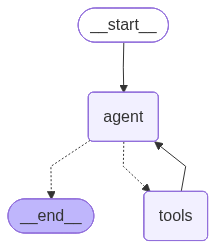

In [32]:
# ✨ 드디어 최종 에이전트를 생성합니다!
# 지금까지 준비한 모델, 모든 도구들, 그리고 상세한 지침서를 `create_react_agent`에 전달하여
# 우리의 똑똑한 '딥 에이전트'를 만듭니다.
agent = create_react_agent(
	model, all_tools, prompt=INSTRUCTIONS, state_schema=DeepAgentState
)

# 📊 생성된 에이전트의 아키텍처를 다이어그램으로 시각화하여 확인해봅시다.
# 에이전트가 어떤 흐름으로 생각하고 행동하는지 한눈에 파악할 수 있어요.
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [33]:
from utils import format_messages

result = agent.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": "Give me an overview of Model Context Protocol (MCP).",
            }
        ],
    }
)

format_messages(result["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Give me an overview of Model Context Protocol (MCP).                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "status": "pending",                                                                                      │
│       "content": "Search for \"Model Context Protocol (MCP)\" to get an overview."                              │
│     },                                                                                                          │
│     {                                                                                                           │
│       "status": "pending",                                                                                      │
│       "content": "Read the search results and synthesize an answer."                                            │
│     },                                                                                                          │
│     {                                                                                                           │
│       "status": "pending",                                                                                      │
│       "content": "Provide the overview to the user."                                                            │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: ad2cd896-6fc5-4f63-a408-bb354004b46e                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Search for "Model Context Protocol (MCP)" to get an overview.', 'status':    │
│ 'pending'}, {'content': 'Read the search results and synthesize an answer.', 'status': 'pending'}, {'content':  │
│ 'Provide the overview to the user.', 'status': 'pending'}]                                                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: read_todos                                                                                        │
│    Args: {}                                                                                                     │
│    ID: 3b633515-6e34-456f-96a5-cb0a21821dbf                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Current TODO List:                                                                                              │
│ 1. ⏳ Search for "Model Context Protocol (MCP)" to get an overview. (pending)                                   │
│ 2. ⏳ Read the search results and synthesize an answer. (pending)                                               │
│ 3. ⏳ Provide the overview to the user. (pending)                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: tavily_search                                                                                     │
│    Args: {                                                                                                      │
│   "query": "Model Context Protocol (MCP) overview"                                                              │
│ }                                                                                                               │
│    ID: 6c8b008c-cce5-4c96-a678-d186cf9b95a7                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ 🔍 'Model Context Protocol (MCP) overview'에 대한 1개의 결과를 찾았습니다:                                      │
│                                                                                                                 │
│ - mcp_protocol_overview_ibm_C_gc8D7_.md: This article provides an overview of the Model Context Protocol (MCP). │
│ It defines MCP as a standardization layer enabling AI applications, particularly AI agents and LLMs, to         │
│ communicate effectively with external services like tools and databases. The key information type is an         │
│ explanatory analysis of a technical protocol. The most significant points are that MCP establishes an open      │
│ standard for AI-tool interactions, acting as a universal connector for "plug-and-play" tool integration. It     │
│ streamlines the efficient and structured use of context for AI models, supporting robust multi-agent systems    │
│ through its client/server architecture....                                                                      │
│                                                                                                                 │
│ 파일: mcp_protocol_overview_ibm_C_gc8D7_.md                                                                     │
│ 💡 필요할 때 `read_file()`을 사용하여 전체 세부 정보에 액세스하세요.                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: read_todos                                                                                        │
│    Args: {}                                                                                                     │
│    ID: f69bd5f4-0e2f-49c2-b18a-2e3cf89d2467                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Current TODO List:                                                                                              │
│ 1. ⏳ Search for "Model Context Protocol (MCP)" to get an overview. (pending)                                   │
│ 2. ⏳ Read the search results and synthesize an answer. (pending)                                               │
│ 3. ⏳ Provide the overview to the user. (pending)                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: read_file                                                                                         │
│    Args: {                                                                                                      │
│   "file_path": "mcp_protocol_overview_ibm_C_gc8D7_.md"                                                          │
│ }                                                                                                               │
│    ID: 5a086295-be1e-4cb8-b26e-f9d41cf018a2                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│      1\t# 검색 결과: What is Model Context Protocol (MCP)? - IBM\n     2\t\n     3\t**URL:**                    │
│ https://www.ibm.com/think/topics/model-context-protocol\n     4\t**쿼리:** Model Context Protocol (MCP)         │
│ overview\n     5\t**날짜:** Fri Oct 17, 2025\n     6\t\n     7\t## 요약\n     8\tThis article provides an       │
│ overview of the Model Context Protocol (MCP). It defines MCP as a standardization layer enabling AI             │
│ applications, particularly AI agents and LLMs, to communicate effectively with external services like tools and │
│ databases. The key information type is an explanatory analysis of a technical protocol. The most significant    │
│ points are that MCP establishes an open standard for AI-tool interactions, acting as a universal connector for  │
│ "plug-and-play" tool integration. It streamlines the efficient and structured use of context for AI models,     │
│ supporting robust multi-agent systems through its client/server architecture.\n     9\t\n    10\t## 원본        │
│ 콘텐츠\n    11\tWhat is Model Context Protocol (MCP)? | IBM\n    12\t\n    13\t\n    14\t\n    15\t\n    16\t\n │
│ 17\tWhat is Model Context Protocol (MCP)?\n    18\t=====================================\n    19\t\n            │
│ 20\t![](https://assets.ibm.com/is/image/ibm/ibm_think_projectkavya_twist_still_4k?ts=1746859205539&dpr=off)\n   │
│ 21\t\n    22\tAI Agents\n    23\t\n    24\t* [Welcome](https://www.ibm.com/think/ai-agents#605511093)\n         │
│ 25\t* Caret right\n    26\t  Introduction\n    27\t  +                                                          │
│ [Overview](https://www.ibm.com/think/topics/ai-agents#7281535)\n    28\t  + [AI agents vs AI                    │
│ assistants](https://www.ibm.com/think/topics/ai-agents-vs-ai-assistants#7281536)\n    29\t  + [Agentic          │
│ AI](https://www.ibm.com/think/topics/agentic-ai#7281537)\n    30\t  + [Agentic AI vs generative                 │
│ AI](https://www.ibm.com/think/topics/agentic-ai-vs-generative-ai#7281538)\n    31\t  + Caret right\n    32\t    │
│ AI agent development\n    33\t    - [What is AI agent                                                           │
│ development?](https://www.ibm.com/think/topics/ai-agent-development#1083937704)\n    34\t    -                  │
│ [AgentOps](https://www.ibm.com/think/topics/agentops#1083937705)\n    35\t  + Caret right\n    36\t    Types of │
│ AI agents\n    37\t    - [Overview](https://www.ibm.com/think/topics/ai-agent-types#578379079)\n    38\t    -   │
│ [Simple reflex agent](https://www.ibm.com/think/topics/simple-reflex-agent#578379080)\n    39\t* Caret right\n  │
│ 40\t  Components\n    41\t  + [Overview](https://www.ibm.com/think/topics/components-of-ai-agents#498277090)\n  │
│ 42\t  + Caret right\n    43\t    Agentic workflows\n    44\t    - [What are agentic                             │
│ workflows?](https://www.ibm.com/think/topics/agentic-workflows#732739700)\n    45\t    - [Tutorial: Agentic     │
│ workflows](https://www.ibm.com/think/tutorials/build-agentic-workflows-langgraph-granite#732739699)\n    46\t   │
│ + [Communication](https://www.ibm.com/think/topics/ai-agent-communication#498277088)\n    47\t  +               │
│ [Learning](https://www.ibm.com/think/topics/ai-agent-learning#498277087)\n    48\t  +                           │
│ [Memory](https://www.ibm.com/think/topics/ai-agent-memory#498277086)\n    49\t  +                               │
│ [Perception](https://www.ibm.com/think/topics/ai-agent-perception#498277085)\n    50\t  +                       │
│ [Planning](https://www.ibm.com/think/topics/ai-agent-planning#498277084)\n    51\t  +                           │
│ [Reasoning](https://www.ibm.com/think/topics/agentic-reasoning#498277083)\n    52\t  + Caret right\n    53\t    │
│ Tool calling\n    54\t    - [What is tool calling?](https://www.ibm.co

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Model Context Protocol (MCP)는 AI 애플리케이션, 특히 AI 에이전트 및 대규모 언어 모델(LLM)이 도구 및             │
│ 데이터베이스와 같은 외부 서비스와 효과적으로 통신할 수 있도록 하는 표준화 계층입니다. 이는 AI-도구 상호 작용을  │
│ 위한 개방형 표준을 설정하여 "플러그 앤 플레이" 도구 통합을 위한 범용 커넥터 역할을 합니다.                      │
│                                                                                                                 │
│ MCP의 주요 목적은 AI 모델이 컨텍스트를 효율적이고 구조화된 방식으로 사용할 수 있도록 간소화하여 강력한 다중     │
│ 에이전트 시스템을 지원하는 것입니다. 이는 클라이언트/서버 아키텍처를 통해 달성됩니다.                           │
│                                                                                                                 │
│ **MCP의 주요 구성 요소:**                                                                                       │
│                                                                                                                 │
│ *   **MCP 호스트:** 사용자 요청을 수신하고 MCP를 통해 컨텍스트에 액세스하는 AI 애플리케이션입니다. 여기에는     │
│ 오케스트레이션 로직이 포함되며 각 클라이언트를 서버에 연결할 수 있습니다.                                       │
│ *   **MCP 클라이언트:** 호스트와 서버 간의 통신을 처리합니다. 사용자 요청을 개방형 프로토콜이 처리할 수 있는    │
│ 구조화된 형식으로 변환합니다. 클라이언트는 세션 관리자 역할을 하며 응답을 구문 분석하고 오류를 처리하며 응답이  │
│ 관련성이 있고 적절한지 확인합니다.                                                                              │
│ *   **MCP 서버:** 사용자 요청을 서버 작업으로 변환하여 LLM에 컨텍스트를 제공하는 외부 서비스입니다. Slack,      │
│ GitHub, Git, Docker 또는 웹 검색과 같은 통합이 포함될 수 있습니다. 서버는 리소스(정보 검색), 도구(측면 효과를   │
│ 수행하는 도구와의 정보 교환) 및 프롬프트(LLM-서버 통신을 위한 재사용 가능한 템플릿)를 통해 데이터를 노출합니다. │
│                                                                                                                 │
│ **MCP의 이점:**                                                                                                 │
│                                                                                                                 │
│ *   **표준화된 도구 통합:** MCP는 LLM과 외부 서비스 간의 효율적인 통신을 위한 표준을 설정하여 각 도구에 대한    │
│ 사용자 지정 통합 코드를 작성할 필요 없이 "플러그 앤 플레이" 도구 사용을 가능하게 합니다.                        │
│ *   **향상된 컨텍스트 인식:** AI 에이전트가 도구 통합을 위한 표준화된 프로토콜을 준수하면서 컨텍스트를 인식할   │
│ 수 있도록 합니다.                                                                                               │
│ *   **다중 에이전트 오케스트레이션 지원:** 공통 도구를 사용하여 공유 작업 공간을 통해 다중 에이전트             │
│ 오케스트레이션 및 통신을 향상시켜 직접 통합의 필요성을 없앱니다.                                                │
│ *   **RAG(검색 증강 생성) 보완:** MCP는 서버 작업을 통해 벡터 데이터베이스에 연결하여 RAG를 보완할 수 있습니다. │
│ 이는 검색기를 모든 LLM 호출에 전달하는 대신 도구로 데이터베이스를 검색하여 도구를 보다 전략적으로 사용할 수     │
│ 있도록 합니다.                                                                                                  │
│                                                                                                                 │
│ 요약하자면, MCP는 AI 에이전트가 실제 환경에서 자율적으로 작동하고 동적으로 적응하는 데 필수적인 LLM 도구 통합에 │
│ 대한 표준화된 접근 방식을 제공합니다.                                                                           │
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "status": "completed",                                                                                    │
│       "content": "Search for \"Model Context Protocol (MCP)\" to get an overview."                              │
│     },                                                                                                          │
│     {                                                                       

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Search for "Model Context Protocol (MCP)" to get an overview.', 'status':    │
│ 'completed'}, {'content': 'Read the search results and synthesize an answer.', 'status': 'completed'},          │
│ {'content': 'Provide the overview to the user.', 'status': 'completed'}]                                        │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Model Context Protocol (MCP)는 AI 애플리케이션, 특히 AI 에이전트 및 대규모 언어 모델(LLM)이 도구 및             │
│ 데이터베이스와 같은 외부 서비스와 효과적으로 통신할 수 있도록 하는 표준화 계층입니다. 이는 AI-도구 상호 작용을  │
│ 위한 개방형 표준을 설정하여 "플러그 앤 플레이" 도구 통합을 위한 범용 커넥터 역할을 합니다.                      │
│                                                                                                                 │
│ MCP의 주요 목적은 AI 모델이 컨텍스트를 효율적이고 구조화된 방식으로 사용할 수 있도록 간소화하여 강력한 다중     │
│ 에이전트 시스템을 지원하는 것입니다. 이는 클라이언트/서버 아키텍처를 통해 달성됩니다.                           │
│                                                                                                                 │
│ **MCP의 주요 구성 요소:**                                                                                       │
│                                                                                                                 │
│ *   **MCP 호스트:** 사용자 요청을 수신하고 MCP를 통해 컨텍스트에 액세스하는 AI 애플리케이션입니다. 여기에는     │
│ 오케스트레이션 로직이 포함되며 각 클라이언트를 서버에 연결할 수 있습니다.                                       │
│ *   **MCP 클라이언트:** 호스트와 서버 간의 통신을 처리합니다. 사용자 요청을 개방형 프로토콜이 처리할 수 있는    │
│ 구조화된 형식으로 변환합니다. 클라이언트는 세션 관리자 역할을 하며 응답을 구문 분석하고 오류를 처리하며 응답이  │
│ 관련성이 있고 적절한지 확인합니다.                                                                              │
│ *   **MCP 서버:** 사용자 요청을 서버 작업으로 변환하여 LLM에 컨텍스트를 제공하는 외부 서비스입니다. 서버는      │
│ 리소스(정보 검색), 도구(측면 효과를 수행하거나 API를 통해 데이터를 가져올 수 있는 도구와의 정보 교환) 및        │
│ 프롬프트(LLM-서버 통신을 위한 재사용 가능한 템플릿 및 워크플로우)를 통해 데이터를 노출합니다.                   │
│                                                                                                                 │
│ **MCP의 이점:**                                                                                                 │
│                                                                                                                 │
│ *   **표준화된 도구 통합:** MCP는 LLM과 외부 서비스 간의 효율적인 통신을 위한 표준을 설정하여 각 도구에 대한    │
│ 사용자 지정 통합 코드를 작성할 필요 없이 "플러그 앤 플레이" 도구 사용을 가능하게 합니다.                        │
│ *   **향상된 컨텍스트 인식:** AI 에이전트가 도구 통합을 위한 표준화된 프로토콜을 준수하면서 컨텍스트를 인식할   │
│ 수 있도록 합니다.                                                                                               │
│ *   **다중 에이전트 오케스트레이션 및 통신 간소화:** 공통 도구를 사용하여 공유 작업 공간을 통해 다중 에이전트   │
│ 시스템의 오케스트레이션 및 통신을 향상시켜 직접 통합의 필요성을 없앱니다.                                       │
│ *   **RAG(검색 증강 생성) 보완:** MCP는 서버 작업을 통해 벡터 데이터베이스에 연결하여 RAG를 보완할 수 있습니다. │
│ 이는 검색기를 모든 LLM 호출에 전달하는 대신 도구로 데이터베이스를 검색하여 도구를 보다 전략적으로 사용할 수     │
│ 있도록 합니다.                                                                                                  │
│                                                                                                                 │
│ 요약하자면, MCP는 AI 에이전트가 외부 도구 및 데이터 소스와 상호 작용하는 방식을 표준화하여 AI 애플리케이션의    │
│ 개발 및 확장을 간소화하는 데 중요한 역할을 합니다.                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Trace: 
https://smith.langchain.com/public/3a389ec6-8e6e-4f9e-9a82-0d0a9569e6f8/r
<!-- https://smith.langchain.com/public/1df7a10e-1465-499c-a3e0-86c1d5429324/r -->

## 딥 에이전트 패키지 사용

이제 기본 패턴을 이해하셨습니다! 

[ `deepagents` 패키지](https://github.com/hwchase17/deepagents)를 간단한 추상화로 사용할 수 있습니다:

* 파일 시스템 도구가 포함되어 있습니다.
* todo 도구가 포함되어 있습니다.
* 작업 도구가 포함되어 있습니다.

하위 에이전트와 하위 에이전트가 사용할 도구만 제공하면 됩니다.

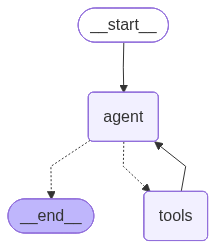

In [34]:
from deepagents import create_deep_agent

# 🎁 `deepagents` 패키지를 사용하여 훨씬 더 간편하게 딥 에이전트를 생성합니다!
# 이 함수는 파일 시스템, TODO, 작업 위임 도구를 자동으로 포함해주기 때문에
# 우리는 하위 에이전트와 그들이 사용할 도구, 그리고 지침만 제공하면 됩니다.
# 훨씬 깔끔하고 편리하죠?
agent = create_deep_agent(
	sub_agent_tools,
	INSTRUCTIONS,
	subagents=[research_sub_agent],
	model=model,
)

# 📊 패키지로 생성한 에이전트의 구조도 한번 살펴볼까요?
# 직접 만들었을 때와 동일한 구조를 가지고 있는지 확인해보세요!
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [35]:
result = agent.invoke(
	{
		"messages": [
			{
				"role": "user",
				"content": "Give me an very brief overview of Model Context Protocol (MCP).",
			}
		],
	}
)

format_messages(result["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Give me an very brief overview of Model Context Protocol (MCP).                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "status": "pending",                                                                                      │
│       "content": "Search for \"Model Context Protocol (MCP)\" to get an overview."                              │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: ac866fd8-81a4-4dd3-8b2e-802dfd7ab205                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Search for "Model Context Protocol (MCP)" to get an overview.', 'status':    │
│ 'pending'}]                                                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "status": "in_progress",                                                                                  │
│       "content": "Search for \"Model Context Protocol (MCP)\" to get an overview."                              │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: 868e1b5f-836f-423f-a387-855e396be652                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Search for "Model Context Protocol (MCP)" to get an overview.', 'status':    │
│ 'in_progress'}]                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: task                                                                                              │
│    Args: {                                                                                                      │
│   "subagent_type": "research-agent",                                                                            │
│   "description": "Provide a very brief overview of Model Context Protocol (MCP)."                               │
│ }                                                                                                               │
│    ID: 71cf5f38-3edf-44c1-a5bd-887d6faf2ee0                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Model Context Protocol (MCP)은 AI 애플리케이션이 외부 서비스, 도구 및 데이터베이스와 통신할 수 있도록 하는      │
│ 표준화 계층입니다. 이는 AI 에이전트의 "플러그 앤 플레이" 도구 통합을 가능하게 하여 개발을 간소화하고 복잡한     │
│ 다중 에이전트 시스템에서 통신 문제를 방지합니다. MCP는 클라이언트/서버 모델을 사용하여 AI 모델 성능 최적화를    │
│ 위해 리소스, 도구 및 프롬프트를 노출합니다.                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "status": "completed",                                                                                    │
│       "content": "Search for \"Model Context Protocol (MCP)\" to get an overview."                              │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: b76691f5-2633-42e3-8f31-c316d9e7867f                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Search for "Model Context Protocol (MCP)" to get an overview.', 'status':    │
│ 'completed'}]                                                                                                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Model Context Protocol (MCP)은 AI 애플리케이션이 외부 서비스, 도구 및 데이터베이스와 통신할 수 있도록 하는      │
│ 표준화 계층입니다. 이는 AI 에이전트의 "플러그 앤 플레이" 도구 통합을 가능하게 하여 개발을 간소화하고 복잡한     │
│ 다중 에이전트 시스템에서 통신 문제를 방지합니다. MCP는 클라이언트/서버 모델을 사용하여 AI 모델 성능 최적화를    │
│ 위해 리소스, 도구 및 프롬프트를 노출합니다.                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Trace: 
https://smith.langchain.com/public/1d626d81-a102-4588-a2fb-cab40a7271f1/r
<!-- https://smith.langchain.com/public/1ae2d7f6-f901-4ebd-b6c3-6657a55f88ae/r -->